In [ ]:
import pandas as pd
import plotly.express as px
import umap
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

from functions.common_functions import *

In [2]:
df = pd.read_csv('../data/processed/mannich_scope-descriptors.csv')

In [3]:
## Initial Processing ##

vt = VarianceThreshold()

parameters = df.iloc[:,5:] ## Set parameters to desired columns ##
thres = vt.fit(parameters)
parameters = thres.transform(parameters)

scaled_data = StandardScaler().fit_transform(parameters)

In [4]:
## Elbow Plot ##

num_reactions = len(df)

reducer = umap.UMAP(
    random_state=25,
    min_dist=0,  # Default is 0.1
    n_neighbors=num_reactions-1,  # Default is 15
    n_components=10)

clustering_embedding = reducer.fit_transform(scaled_data)

range_, inertia = get_clusters(clustering_embedding,50)

fig = px.scatter(x=range_, y=inertia,
                labels={'x':'# of Clusters', 'y':'Inertia'},
                template='simple_white'
                )

fig.update_traces(marker=dict(size=17,
                              line=dict(width=2,
                                        color='Black')),
                  selector=dict(mode='markers'))

fig.update_xaxes(mirror=True)
fig.update_yaxes(mirror=True)

fig.update_layout(
    font_size=20,
)

fig.show()

In [5]:
## Impact of Random Seed on Generality ##
random_seed_list = []
cat_list = []
gen_list = []

for i in range(1,1000):
    labels = k_cluster(clustering_embedding,12,init=i)
    rxn_cluster_df = pd.DataFrame({'Reaction':df['Reaction'],'cluster_label':labels})

    full_df = pd.read_csv('../data/interim/mannich_database_scope.csv')
    full_df = remove_x(full_df,'ee')
    full_df_trim = full_df.loc[:,['Reaction','Catalyst_Type','ee']]
    full_df_clusters = pd.merge(full_df_trim,rxn_cluster_df,how='inner',on='Reaction')

    cats = full_df_clusters['Catalyst_Type'].unique()
    
    for cat in cats:
        generality, clusters, cluster_ee = calc_generality(full_df_clusters,cat,'Catalyst_Type','ee', full_df_clusters['cluster_label'], 80)
        cat_list.append(cat)
        gen_list.append(generality)

random_seed_generality = pd.DataFrame({'catalyst':cat_list,'generality':gen_list})
random_seed_generality = random_seed_generality.set_index('catalyst')


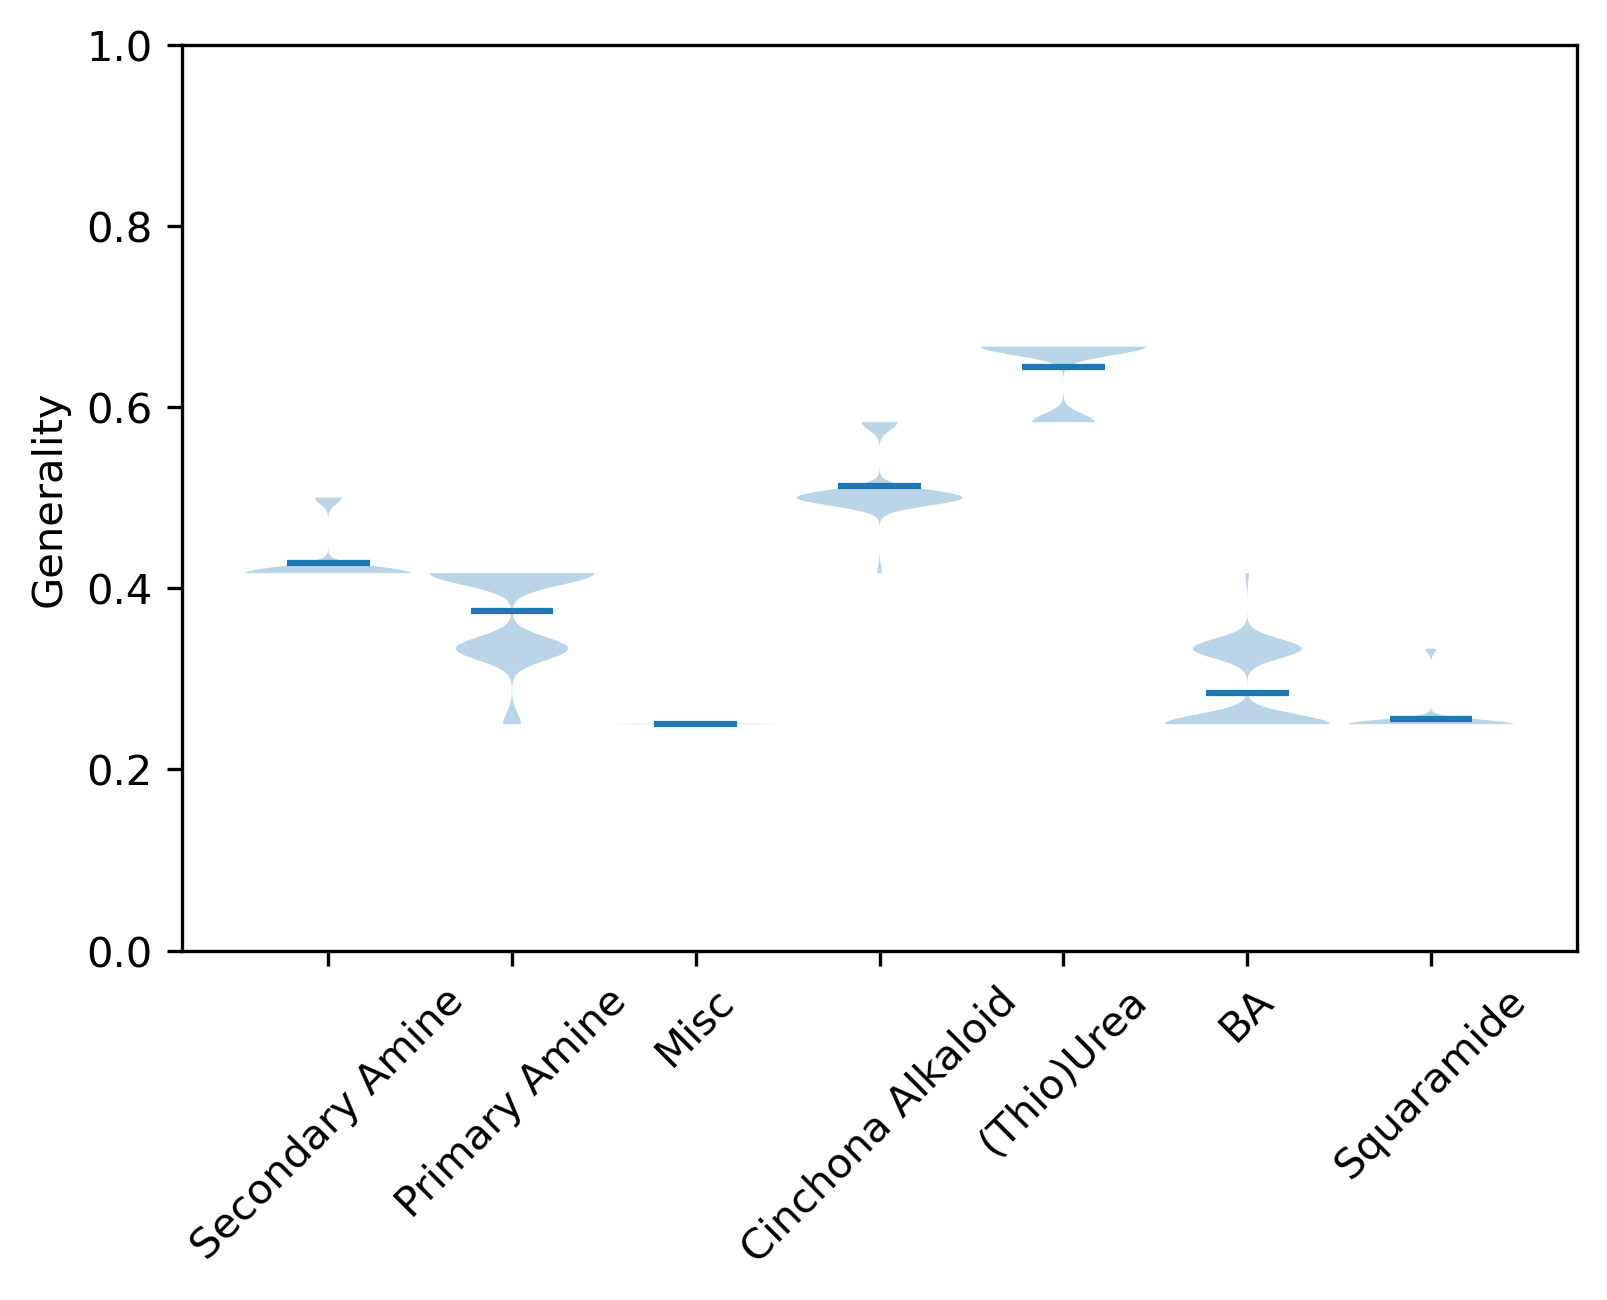

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.violinplot([random_seed_generality.loc['Secondary Amine','generality'],random_seed_generality.loc['Primary Amine','generality'], random_seed_generality.loc['Misc','generality'],
                random_seed_generality.loc['Cinchona Alkaloid','generality'], random_seed_generality.loc['(Thio)Urea','generality'], random_seed_generality.loc['BA','generality'],
                random_seed_generality.loc['Squaramide','generality']], showmeans=True, showextrema=False, widths=0.9)
fig.set_dpi(300)
ax.set_xticks([1,2,3,4,5,6,7])
ax.set_xticklabels(cats)
plt.xticks(rotation=45)
plt.ylabel('Generality')
plt.ylim(0,1)
plt.show()